In [38]:
# Francisco Dominguez Mateos
# 09/05/2021
# Inspired by: https://www.tensorflow.org/tutorials/text/transformer
# Playing with attention

In [39]:
import jax
from jax import random
import jax.numpy as np
from jax.experimental.stax import Dense, serial, Relu, BatchNorm, Dropout
from jax.nn.initializers import uniform
from jax.ops import index_update
# Current convention is to import original numpy as "onp"
import numpy as onp
import matplotlib.pyplot as plt

In [40]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

# Positional encoding

In [41]:
#from: https://www.tensorflow.org/tutorials/text/transformer
def get_angles(pos, i, d_model):
  angle_rates = 1 / onp.power(10000, (2 * (i//2)) / onp.float32(d_model))
  return pos * angle_rates

In [42]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(onp.arange(position)[:, onp.newaxis],
                          onp.arange(d_model)[onp.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = onp.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = onp.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return np.array(pos_encoding)

(1, 2048, 512)


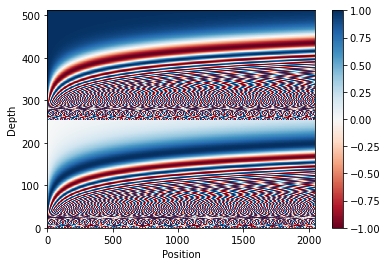

In [43]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]
# Juggle the dimensions for the plot
pos_encoding = np.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = np.transpose(pos_encoding, (2, 1, 0))
pos_encoding = np.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Masking
## Padding Masking

In [44]:
def create_padding_mask(seq):
  seq =seq == 0
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, np.newaxis, np.newaxis, :].astype(float)  # (batch_size, 1, 1, seq_len)

In [45]:
x = np.array([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
pad_mask_x=create_padding_mask(x)
pad_mask_x

DeviceArray([[[[0.0000, 0.0000, 1.0000, 1.0000, 0.0000]]],


             [[[0.0000, 0.0000, 0.0000, 1.0000, 1.0000]]],


             [[[1.0000, 1.0000, 1.0000, 0.0000, 0.0000]]]], dtype=float32)

In [46]:
pad_mask_x.shape

(3, 1, 1, 5)

## Look Ahead Masking

In [47]:
def create_look_ahead_mask(size):
  #mask = 1 - np.linalg.band_part(np.ones((size, size)), -1, 0)
  mask = np.tril(np.ones((size, size)),-1)
  return mask.T  # (seq_len, seq_len)

In [48]:
x = random.uniform(rng,(1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

DeviceArray([[0.0000, 1.0000, 1.0000],
             [0.0000, 0.0000, 1.0000],
             [0.0000, 0.0000, 0.0000]], dtype=float32)

# Attention Scaled

In [49]:
def attention(k,q,v):
    """
    """
    kT=np.swapaxes(k,-1,-2)
    #print("q =",q.shape)
    #print("kT=",kT.shape)
    qk=np.matmul(q,kT)
    #print("qk=",qk.shape)
    dk=k.shape[-1]
    scalled_attention_logits=qk/np.sqrt(dk)
    attention_weights=jax.nn.softmax(scalled_attention_logits)
    #print("attention_weights=",attention_weights.shape)
    output=np.matmul(attention_weights,v)
    return output, attention_weights
def attention_scaled_dot_product(k,q,v,mask=None):
    """
    """
    kT=np.swapaxes(k,-1,-2)
    #print("q =",q.shape)
    #print("kT=",kT.shape)
    qk=np.matmul(q,kT)
    #print("qk=",qk.shape)
    dk=k.shape[-1]
    scalled_attention_logits=qk/np.sqrt(dk)
    # Apply the mask
    if mask is not None:
        scaled_attention_logits+=(mask*-1e9)
    attention_weights=jax.nn.softmax(scalled_attention_logits)
    #print("attention_weights=",attention_weights.shape)
    output=np.matmul(attention_weights,v)
    return output, attention_weights

In [50]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

In [51]:
temp_k = np.array([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]])  # (4, 3)

temp_v = np.array([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]])  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = np.array([[0, 10, 0]])  # (1, 3)
o,a=attention_scaled_dot_product(temp_k,temp_q,temp_v)
print("a=",a)
print("o=",o)

a= [[0.0000 1.0000 0.0000 0.0000]]
o= [[10.0000 0.0000]]


In [52]:
temp_q = np.array([[0, 0, 10]])  # (1, 3)
o,a=attention_scaled_dot_product(temp_k,temp_q,temp_v)
print("a=",a)
print("o=",o)

a= [[0.0000 0.0000 0.5000 0.5000]]
o= [[550.0000 5.5000]]


In [53]:
temp_q = np.array([[10, 10, 0]])  # (1, 3)
o,a=attention_scaled_dot_product(temp_k,temp_q,temp_v)
print("a=",a)
print("o=",o)

a= [[0.5000 0.5000 0.0000 0.0000]]
o= [[5.5000 0.0000]]


In [54]:
temp_q = np.array([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]])  # (3, 3)
o,a=attention_scaled_dot_product(temp_k,temp_q,temp_v)
print("a=")
print(a)
print("o=")
print(o)

a=
[[0.0000 0.0000 0.5000 0.5000]
 [0.0000 1.0000 0.0000 0.0000]
 [0.5000 0.5000 0.0000 0.0000]]
o=
[[550.0000 5.5000]
 [10.0000 0.0000]
 [5.5000 0.0000]]


# Multi Head Attention Layer

In [55]:
def MultiHeadLayer(embed_dim, num_heads=8):
    assert embed_dim % num_heads==0
    depth=embed_dim//num_heads
    init_wk ,wk =Dense(embed_dim)
    init_wq ,wq =Dense(embed_dim)
    init_wv ,wv =Dense(embed_dim)
    init_lin,lin=Dense(embed_dim)
    
    def init_fun(rng,input_shape):
        rng_k,rng_q,rng_v,rng_lin=random.split(rng,4)
        shape, param_k   =init_wk (rng_k  ,input_shape)
        shape, param_q   =init_wq (rng_q  ,input_shape)
        shape, param_v   =init_wv (rng_v  ,input_shape)
        shape, param_lin =init_lin(rng_lin,input_shape)
        return shape,(param_k,param_q,param_v,param_lin)

    def split_heads(x,batch_size):
        x=np.reshape(x,(batch_size,-1,num_heads,depth))
        x=np.transpose(x,(0,2,1,3))
        return x
    
    def apply_fun(params,x,mask=None):
        batch_size=x[0].shape[0]
        k,q,v=x
        param_k,param_q,param_v,param_lin=params
        k=wk(param_k,k)
        q=wq(param_q,q)
        v=wv(param_v,v)
        #print("k=",k.shape)
        #print("q=",q.shape)
        #print("v=",v.shape)
        k=split_heads(k,batch_size)
        q=split_heads(q,batch_size)
        v=split_heads(v,batch_size)
        #print("k=",k.shape)
        #print("q=",q.shape)
        #print("v=",v.shape)
        a,aw=attention_scaled_dot_product(k,q,v)
        sa=np.transpose(a,(0,2,1,3))
        ca=np.reshape(sa,(batch_size,-1,embed_dim))
        output=lin(param_lin,ca)
        return output,aw
    
    return init_fun,apply_fun 

In [56]:
in_shape = (1,60,512)
init_mha,mha=MultiHeadLayer(in_shape[2])
output_shape, params = init_mha(rng, in_shape)
fake_data=random.uniform(rng,in_shape)
print("output_shape=",output_shape)
o,aw=mha(params,(fake_data,fake_data,fake_data))
print("o =",o.shape)
print("aw=",aw.shape)

output_shape= (1, 60, 512)
o = (1, 60, 512)
aw= (1, 8, 60, 60)


In [57]:
#Normalizing ..... to implement layer normalization
temp_a = np.array([[[0, 0, 10],
                   [0, 10, 0],
                   [0, 10, 0],
                   [10, 10, 0]],
                  [[0, 0, 5],
                   [0, 5, 0],
                   [0, 6, 0],
                   [5, 5, 0]]])
print("temp_a=",temp_a.shape)
print(jax.nn.normalize(temp_a,axis=0))
print(jax.nn.normalize(temp_a,axis=1))
print(jax.nn.normalize(temp_a,axis=2))
print(jax.nn.normalize(temp_a,axis=(1,2)))

temp_a= (2, 4, 3)
[[[0.0000 0.0000 1.0000]
  [0.0000 1.0000 0.0000]
  [0.0000 1.0000 0.0000]
  [1.0000 1.0000 0.0000]]

 [[0.0000 0.0000 -1.0000]
  [0.0000 -1.0000 0.0000]
  [0.0000 -1.0000 0.0000]
  [-1.0000 -1.0000 0.0000]]]
[[[-0.5774 -1.7321 1.7321]
  [-0.5774 0.5774 -0.5774]
  [-0.5774 0.5774 -0.5774]
  [1.7321 0.5774 -0.5774]]

 [[-0.5773 -1.7056 1.7320]
  [-0.5773 0.4264 -0.5773]
  [-0.5773 0.8528 -0.5773]
  [1.7320 0.4264 -0.5773]]]
[[[-0.7071 -0.7071 1.4142]
  [-0.7071 1.4142 -0.7071]
  [-0.7071 1.4142 -0.7071]
  [0.7071 0.7071 -1.4142]]

 [[-0.7071 -0.7071 1.4142]
  [-0.7071 1.4142 -0.7071]
  [-0.7071 1.4142 -0.7071]
  [0.7071 0.7071 -1.4142]]]
[[[-0.8452 -0.8452 1.1832]
  [-0.8452 1.1832 -0.8452]
  [-0.8452 1.1832 -0.8452]
  [1.1832 1.1832 -0.8452]]

 [[-0.8409 -0.8409 1.0996]
  [-0.8409 1.0996 -0.8409]
  [-0.8409 1.4877 -0.8409]
  [1.0996 1.0996 -0.8409]]]


# Pointwise Feedforward Network

In [58]:
def PointWiseFeedForwardNetwork(embeb_dim,dff):
    return serial(Dense(dff),Relu,Dense(embeb_dim))

In [59]:
in_shape = (64,50,512)
init_dff,dff=PointWiseFeedForwardNetwork(512,2048)
output_shape, params = init_dff(rng, in_shape)
fake_data=random.uniform(rng,in_shape)
print("output_shape=",output_shape)
o=dff(params,fake_data)
print("o =",o.shape)

output_shape= (64, 50, 512)
o = (64, 50, 512)


# Encoder Layer

In [60]:
def EncoderLayer(embed_dim,num_heads,dff,rate=0.1):
    init_mha,mha=MultiHeadLayer(embed_dim,num_heads)
    init_ffn,ffn=PointWiseFeedForwardNetwork(embed_dim,dff)
    init_ln1,ln1=BatchNorm()
    init_ln2,ln2=BatchNorm()
    init_do1,do1=Dropout(rate)
    init_do2,do2=Dropout(rate)
    def init_fun(rnd,input_shape):
        rng_mha,rng_ffn,rng_ln1,rng_ln2,rng_do1,rng_do2=random.split(rng,6)
        shape, param_mha   =init_mha (rng_mha  ,input_shape)
        shape, param_ffn   =init_ffn (rng_ffn  ,input_shape)
        shape, param_ln1   =init_ln1 (rng_ln1  ,input_shape)
        shape, param_ln2   =init_ln2 (rng_ln2  ,input_shape)
        shape, param_do1   =init_do1 (rng_do1  ,input_shape)
        shape, param_do2   =init_do2 (rng_do2  ,input_shape)
        return in_shape,(param_mha,param_ffn,param_ln1,param_ln2,param_do1,param_do2)
    def apply_fun(params,x,rng,training=True,mask=None):
        param_mha,param_ffn,param_ln1,param_ln2,param_do1,param_do2=params
        attn_output, _=mha(param_mha,(x,x,x),mask)
        attn_output=do1(param_do1,attn_output,rng=rng,mode=training)
        #print("x=",x.shape)
        #print("attn_output",attn_output.shape)
        out1=ln1(param_ln1,x+attn_output)
        
        ffn_output=ffn(param_ffn,out1)
        ffn_output=do2(param_do2,ffn_output,rng=rng,mode=training)
        out2=ln2(param_ln2,out1+ffn_output)
        return out2
    return init_fun,apply_fun

In [61]:
in_shape = (64,43,512)
init_enl,enl=EncoderLayer(512,8,2048)
output_shape, params = init_enl(rng, in_shape)
fake_data=random.uniform(rng,in_shape)
print("output_shape=",output_shape)
oel=enl(params,fake_data,rng)
print("oel=",oel.shape)

output_shape= (64, 43, 512)
oel= (64, 43, 512)


# Decoder Layer

In [62]:
def DecoderLayer(embed_dim,num_heads,dff,rate=0.1):
    init_ma1,ma1=MultiHeadLayer(embed_dim,num_heads)
    init_ma2,ma2=MultiHeadLayer(embed_dim,num_heads)
    init_ffn,ffn=PointWiseFeedForwardNetwork(embed_dim,dff)
    init_ln1,ln1=BatchNorm()
    init_ln2,ln2=BatchNorm()
    init_ln3,ln3=BatchNorm()
    init_do1,do1=Dropout(rate)
    init_do2,do2=Dropout(rate)
    init_do3,do3=Dropout(rate)
    def init_fun(rnd,input_shape):
        rng_ma1,rng_ma2,rng_ffn,rng_ln1,rng_ln2,rng_ln3,rng_do1,rng_do2,rng_do3=random.split(rng,9)
        shape, param_ma1   =init_ma1 (rng_ma1  ,input_shape)
        shape, param_ma2   =init_ma2 (rng_ma2  ,input_shape)
        shape, param_ffn   =init_ffn (rng_ffn  ,input_shape)
        shape, param_ln1   =init_ln1 (rng_ln1  ,input_shape)
        shape, param_ln2   =init_ln2 (rng_ln2  ,input_shape)
        shape, param_ln3   =init_ln3 (rng_ln3  ,input_shape)
        shape, param_do1   =init_do1 (rng_do1  ,input_shape)
        shape, param_do2   =init_do2 (rng_do2  ,input_shape)
        shape, param_do3   =init_do3 (rng_do3  ,input_shape)
        return input_shape,(param_ma1,param_ma2,param_ffn,param_ln1,param_ln2,param_ln3,param_do1,param_do2,param_do3)
    def apply_fun(params,x,enc_output,rng,training=True,mask_look_ahead=None,mask_padding=None):
        param_ma1,param_ma2,param_ffn,param_ln1,param_ln2,param_ln3,param_do1,param_do2,param_do3=params
        att1, att1_w=ma1(param_ma1,(x,x,x),mask_look_ahead)
        att1        =do1(param_do1,att1,rng=rng,mode=training)
        out1        =ln1(param_ln1,x+att1)
        
        att2, att2_w=ma2(param_ma2,(enc_output,out1,enc_output),mask_padding)
        att2        =do2(param_do2,att2,rng=rng,mode=training)
        out2        =ln2(param_ln2,out1+att2)
        
        ffn_output=ffn(param_ffn,out2)
        ffn_output=do3(param_do3,ffn_output,rng=rng,mode=training)
        out3=ln3(param_ln3,out2+ffn_output)
        return out2, att1_w, att2_w
    return init_fun,apply_fun

In [63]:
in_shape = (64,43,512)
init_dcl,dcl=DecoderLayer(512,8,2048)
output_shape, params = init_dcl(rng, in_shape)
fake_data=random.uniform(rng,in_shape)
print("output_shape=",output_shape)
o,_,_=dcl(params,fake_data,oel,rng)
print("o =",o.shape)

output_shape= (64, 43, 512)
o = (64, 43, 512)


# Embedding

In [64]:
# I don't know if this works fine
# from: https://github.com/google/jax/pull/2157/files
def Embedding(vocab_size,
              embedding_size,
              padding_idx=None,
              embedding_init=uniform()):
  """Layer construction function for an embedding layer."""
  def init_fun(rng, input_shape):
    embedding_shape = (vocab_size, embedding_size)
    embedding_table = embedding_init(rng, embedding_shape)
    if padding_idx is not None:
      embedding_table = index_update(embedding_table, padding_idx, 0.)
    output_shape = input_shape + (embedding_size,)
    return output_shape, (embedding_table,)

  def apply_fun(params, inputs):
    embedding_table = params[0]
    return embedding_table[inputs]

  return init_fun, apply_fun

In [65]:
in_shape = (2,8)
init_emb,emb=Embedding(10,2)
output_shape, params = init_emb(rng, in_shape)
print("params=",params)
fake_data=random.randint(rng,in_shape,minval=0,maxval=10)
print("fake_data=",fake_data)
print("output_shape=",output_shape)
o=emb(params,fake_data)
print("o =",o.shape)
print(o)

params= (DeviceArray([[0.0016, 0.0016],
             [0.0041, 0.0009],
             [0.0077, 0.0002],
             [0.0025, 0.0047],
             [0.0042, 0.0036],
             [0.0008, 0.0003],
             [0.0095, 0.0060],
             [0.0004, 0.0024],
             [0.0081, 0.0042],
             [0.0070, 0.0030]], dtype=float32),)
fake_data= [[4 2 3 2 4 2 2 3]
 [5 4 3 5 0 3 2 7]]
output_shape= (2, 8, 2)
o = (2, 8, 2)
[[[0.0042 0.0036]
  [0.0077 0.0002]
  [0.0025 0.0047]
  [0.0077 0.0002]
  [0.0042 0.0036]
  [0.0077 0.0002]
  [0.0077 0.0002]
  [0.0025 0.0047]]

 [[0.0008 0.0003]
  [0.0042 0.0036]
  [0.0025 0.0047]
  [0.0008 0.0003]
  [0.0016 0.0016]
  [0.0025 0.0047]
  [0.0077 0.0002]
  [0.0004 0.0024]]]


# Encoder Model

In [66]:
def Encoder(num_layers,embed_dim,num_heads,dff,input_vocab_size,maximum_position_encoding,rate=0.1):
    init_emb,emb=Embedding(input_vocab_size,embed_dim)
    pos_encoding=positional_encoding(maximum_position_encoding,embed_dim)
    enc_layers=[EncoderLayer(embed_dim,num_heads,dff,rate) for _ in range(num_layers)]
    init_dou,dou=Dropout(rate)
    def init_fun(rng,input_shape):
        rng_emb,rng_pos,rng_dou=random.split(rng,3)
        out_shape, param_emb=init_emb(rng_emb,input_shape)
        shape, param_dou=init_dou(rng_dou,out_shape)
        params_enc=[]
        for init_enc,_ in enc_layers:
            rng_enc,rng=random.split(rng)
            shape, param_enc=init_enc(rng_enc,out_shape)
            params_enc.append(param_enc)
        return out_shape,(param_emb,params_enc,param_dou)
    def apply_fun(params,x,rng,training=True,mask=None):
        param_emb,params_enc,param_dou=params
        seq_len=x.shape[1]
        x =emb(param_emb,x)
        x*=np.sqrt(embed_dim)
        x+=pos_encoding[:, :seq_len, :]
        x=dou(param_dou,x,rng=rng,mode=training)
        for i,layer in enumerate(enc_layers):
            _,enc=layer
            x=enc(params_enc[i],x,rng,training,mask)
        return x
    return init_fun,apply_fun

In [67]:
in_shape = (64,62)
init_enc,enc=Encoder(2,512,8,2048,8500,10000)
output_shape, params = init_enc(rng, in_shape)
fake_data=random.randint(rng,in_shape,minval=0,maxval=200)
print("output_shape=",output_shape)
oen=enc(params,fake_data,rng)
print("oen =",oen.shape)

output_shape= (64, 62, 512)
oen = (64, 62, 512)


# Decoder Model

In [68]:
def Decoder(num_layers,embed_dim,num_heads,dff,target_vocab_size,maximum_position_encoding,rate=0.1):
    init_emb,emb=Embedding(target_vocab_size,embed_dim)
    pos_encoding=positional_encoding(maximum_position_encoding,embed_dim)
    dec_layers=[DecoderLayer(embed_dim,num_heads,dff,rate) for _ in range(num_layers)]
    init_dou,dou=Dropout(rate)
    def init_fun(rng,input_shape):
        rng_emb,rng_dou,rng=random.split(rng,3)
        out_shape, param_emb=init_emb(rng_emb,input_shape)
        shape, param_dou=init_dou(rng_dou,out_shape)
        params_dec=[]
        for init_dec,_ in dec_layers:
            rng_dec,rng=random.split(rng)
            shape, param_dec=init_dec(rng_dec,out_shape)
            params_dec.append(param_dec)
        return out_shape,(param_emb,params_dec,param_dou)
    def apply_fun(params,x,enc_output,rng,training=True,mask_look_ahead=None,mask_padding=None):
        param_emb,params_dec,param_dou=params
        seq_len=x.shape[1]
        attn_w={}
        x =emb(param_emb,x)
        x*=np.sqrt(embed_dim)
        x+=pos_encoding[:, :seq_len, :]
        x=dou(param_dou,x,rng=rng,mode=training)
        for i,layer in enumerate(dec_layers):
            _,dec=layer
            x, att1_w,att2_w=dec(params_dec[i],x,enc_output,rng,training,mask_look_ahead,mask_padding)
            attn_w[f'decoder_layer{i+1}_block1']=att1_w
            attn_w[f'decoder_layer{i+1}_block2']=att2_w
        return x,attn_w 
    return init_fun,apply_fun

In [69]:
in_shape = (64,26)
init_dec,dec=Decoder(2,512,8,2048,8000,5000)
output_shape, params = init_dec(rng, in_shape)
fake_data=random.randint(rng,in_shape,minval=0,maxval=200)
print("output_shape=",output_shape)
odc,attn_w=dec(params,fake_data,oen,rng)
print("odc =",odc.shape)
print("attn_w=",attn_w['decoder_layer2_block2'].shape)

output_shape= (64, 26, 512)
odc = (64, 26, 512)
attn_w= (64, 8, 26, 62)


# Transformer Model

In [70]:
def Transformer(num_layers, embed_dim, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    init_enc,enc=Encoder(num_layers,embed_dim,num_heads,dff,target_vocab_size,pe_input ,rate=0.1)
    init_dec,dec=Decoder(num_layers,embed_dim,num_heads,dff,target_vocab_size,pe_target,rate=0.1)
    init_fnl,fnl=Dense(target_vocab_size)
    def init_fun(rng,input_enc_shape,input_dec_shape):
        rng_enc,rng_dec,rng_fnl=random.split(rng,3)
        output_enc_shape, param_enc=init_enc(rng_enc,input_enc_shape)
        output_dec_shape, param_dec=init_dec(rng_dec,input_dec_shape)
        output_shape    , param_fnl=init_fnl(rng_fnl,output_dec_shape)
        return output_shape,(param_enc,param_dec,param_fnl)
    def apply_fun(params,enc_x,dec_x,rng,training=True,mask_enc_padding=None,mask_look_ahead=None,mask_dec_padding=None):
        param_enc,param_dec,param_fnl=params
        enc_output       =enc(param_enc,enc_x,rng,training,mask_enc_padding)
        dec_output,attn_w=dec(param_dec,dec_x,enc_output,rng,training,mask_look_ahead,mask_dec_padding)
        final_output     =fnl(param_fnl,dec_output)
        return final_output,attn_w
    return init_fun,apply_fun

In [71]:
in_enc_shape = (64,38)
in_dec_shape = (64,36)
init_trn,trn=Transformer(2,512,8,2048,8500,8000,10000,6000)
output_shape, params = init_trn(rng, in_enc_shape,in_dec_shape)
fake_enc_data=random.randint(rng,in_enc_shape,minval=0,maxval=200)
fake_dec_data=random.randint(rng,in_dec_shape,minval=0,maxval=200)
print("output_shape=",output_shape)
otr,attn_w=trn(params,fake_enc_data,fake_dec_data,rng)
print("otr =",otr.shape)
print("attn_w=",attn_w['decoder_layer2_block2'].shape)

output_shape= (64, 36, 8000)
otr = (64, 36, 8000)
attn_w= (64, 8, 36, 38)


# Training

In [72]:
num_layers = 4
embed_dim = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [73]:
#I don't know if this is differentiable
def SparseCategoricalCrossEntropy(l,y):
    return -np.log(y[l])
def SparseCategoricalCrossEntropyFromLogits(l,y):
    return y[l]

In [74]:
loss_object=SparseCategoricalCrossEntropyFromLogits

def loss_function(real, pred):
  mask = np.logical_not(real==0)
  loss_ = loss_object(real, pred)

  mask = mask.astype(loss_.dtype)
  loss_ *= mask

  return np.sum(loss_)/np.sum(mask)

def accuracy_function(real, pred):
  accuracies = real == np.argmax(pred, axis=2)

  mask = np.logical_not(real==0)
  accuracies = np.logical_and(mask, accuracies)

  accuracies =accuracies.astype(float)
  mask = mask.astype(float)
  return np.sum(accuracies)/np.sum(mask)

In [75]:
init_t,transformer=Transformer(
    num_layers=num_layers,
    embed_dim=embed_dim,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size =10000, #tokenizers.pt.get_vocab_size(),
    target_vocab_size=10000, #tokenizers.en.get_vocab_size(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate
)

In [76]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tar.shape[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = np.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [77]:
def train_step(input,target):
    tar_inp =target[:, :-1]
    tar_real=target[:,1:  ]
    encpadding_mask,combined_mask,dec_padding_mask=create_masks(innp,tar_inp)
    predictions, _ =transformer(inp,tar_inp,True,enc_padding_mask,combined_mask,dec_padding_mask)
    loss=loss_function(tar_real,predictions)